#### **Natural Language Processing** Applications

Based on and with modifications from http://d2l.ai/

#### **1. Sentiment Analysis Dataset**

Sentiment analysis is a text classification which transformed a varying length sequence into a fixed length category. We use Stanford movie reviews - a large dataset, with training and testing sets.

In [ ]:
import dl_modules

In [ ]:
data_dir = download_extract('aclImdb', 'aclImdb')

def read_imdb(data_dir, is_train):
    data, labels = [], []
    for label in ('pos', 'neg'):
        folder_name = os.path.join(data_dir, 'train' if is_train else 'test', label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.read().decode('utf-8').replace('\n', '')
                data.append(review)
                labels.append(1 if label == 'pos' else 0)
    return data, labels

train_data = read_imdb(data_dir, is_train=True)
print('Training set:', len(train_data[0]))

/tmp/ipython-input-2094893403.py:12: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  fp.extractall(base_dir)


Training set: 25000


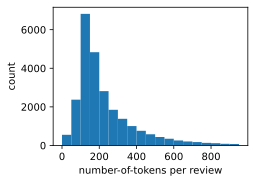

In [ ]:
''' Preprocessing the Dataset - create a vocabulary out of the dataset '''
train_token = tokenize(train_data[0], token='word')
vocab = Vocab(train_token, min_freq=5, reserved_tokens=['<pad>'])

''' Plot the historgram of review lengths in tokens '''
set_figsize()
plt.xlabel('number-of-tokens per review')
plt.ylabel('count')
plt.hist([len(line) for line in train_token], bins=range(0, 1000, 50))

''' Reviews have varying lengths, process a mini-batch at each time '''
num_steps = 500
train_features = torch.tensor([truncate_pad(
    vocab[line], num_steps, vocab['<pad>']) for line in train_token])
train_labels = torch.tensor(train_data[1])

''' Train data iterator '''
train_iter = load_array((train_features, train_labels), 64)

In [ ]:
''' Put it all together - return train and test data iterators and vocabulary
of the dataset. We transformed varying length text sequence into a fixed-length
text category. After processing we can load large dataset into data iterators
with a vocabulary'''
def load_data_imdb(batch_size, num_steps=500):
    data_dir = download_extract('aclImdb', 'aclImdb')
    train_data = read_imdb(data_dir, True)
    test_data = read_imdb(data_dir, False)
    train_tokens = tokenize(train_data[0], token='word')
    test_tokens = tokenize(test_data[0], token='word')
    vocab = Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])
    train_features = torch.tensor([truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    test_features = torch.tensor([truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
    train_iter = load_array(
        (train_features, torch.tensor(train_data[1])), batch_size)
    test_iter = load_array(
        (test_features, torch.tensor(test_data[1])), batch_size, is_train=False)
    return train_iter, test_iter, vocab

In [ ]:
batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

#### **2. Sentiment Analysis using RNN**

In [ ]:
'''
In classification for sentiment analysis, a varying length text sequence will be
transformed into fixed length categories.
In class BiRNN while each token of a text sequence gets its individual Glove
representation via embedding layer, the entire sequence is encoded by a
bi-directional RNN encoder. The hidden states at the last layer of the
bi-directional LSTM at both initial and final time steps are concatenated as
representation of text sequence. The single text is then transformerd into
output categories by a fully connected layer decoder with pos/neg outputs.
'''
class BiRNN(nn.Module):
    def __init__(self,
          vocab_size, embed_size, num_hiddens, num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.encoder = nn.LSTM(
            embed_size, num_hiddens, num_layers=num_layers, bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        '''
        # If using DataParallel with a single device, inputs might have an extra dimension.
        # Reshape from (1, batch_size, seq_len) to (batch_size, seq_len)
        if inputs.ndim == 3 and inputs.shape[0] == 1:
            inputs = inputs.view(inputs.shape[1], inputs.shape[2])
        '''

        inputs = inputs.long() # Ensure inputs are long
        embeddings = self.embedding(inputs.T) # Shape: (seq_len, batch_size, embed_size)
        self.encoder.flatten_parameters()
        outputs, _ = self.encoder(embeddings)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs

In [ ]:
'''
Construct a bidirectional RNN with two hidden layers to represent single text
for sentiment analysis
'''
embed_size, num_hiddens, num_layers, devices = 100, 100, 2, gpus
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])
net.apply(init_weights);

In [ ]:
'''
Load Pre-trained Word vectors, Glove Embeddings
'''
glove_embedding = TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]

In [ ]:
'''
Use these pretrained word vectors to represemt tokens in the reviews, and we will
not update these vectors during training
'''
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

In [ ]:
def train_batch_nlp(net, X, y, loss, trainer, devices):
    """Train for a minibatch with multiple GPUs """
    if isinstance(X, list):
        # Required for BERT fine-tuning (to be covered later)
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0]).long()
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = accuracy(pred, y)
    return train_loss_sum, train_acc_sum

def train_nlp(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=gpus):
    """Train a model with multiple GPUs """
    timer, num_batches = Timer(), len(train_iter)
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])

    if isinstance(devices, list) and len(devices) >1:
      net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    else:
      device = devices[0]
      net = net.to(device)

    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples,
        # no. of predictions
        metric = Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_nlp(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

loss 0.281, train acc 0.882, test acc 0.851
1173.3 examples/sec on ['cuda:0']


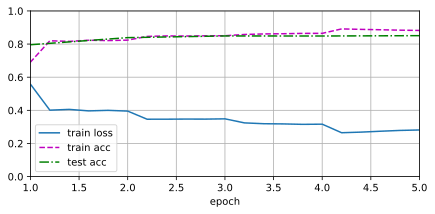

In [ ]:
''' Training and Evaluation of bidirectional RNN for sentiment analysis '''
lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
train_nlp(net, train_iter, test_iter, loss, trainer, num_epochs, devices=gpus)

#### **3. Sentiment Analysis with CNN**

Use textCNN model to demonstrate the CNN architecture for representing text. We compare it with RNN architecture with GloVe pretraining for sentiment analysis.

textCNN Model

Ucing one-dimensional convolution and max-over-time pooling, the textCNN model takes individual pretrained token representations as input, then obtains and transforms sequence representations for the downstream application. Transformations from input to output with the model: **__** Define multiple one-dimensional convolution kernels and perform operations separately on inputs. **__** Perform max-over-time pooling on all the output channels and then concatenate all the scalar pooling outputs as a vector. **__** Transform the concatenated vetor into the output categories using the fully connected layer. **__** Dropout to reduce overfitting.

In [ ]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
                 **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 2)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(2 * embed_size, c, k))

    def forward(self, inputs):
        embeddings = torch.cat((
            self.embedding(inputs), self.constant_embedding(inputs)), dim=2)
        embeddings = embeddings.permute(0, 2, 1)
        encoding = torch.cat([
            torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1)
            for conv in self.convs], dim=1)
        outputs = self.decoder(self.dropout(encoding))
        return outputs

In [ ]:
''' create a textCNN instance with 3 convolutional layers and kernel width
3,4,5 and all with 100 outout channels '''
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)
net.apply(init_weights)

TextCNN(
  (embedding): Embedding(49347, 100)
  (constant_embedding): Embedding(49347, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (decoder): Linear(in_features=300, out_features=2, bias=True)
  (pool): AdaptiveAvgPool1d(output_size=1)
  (relu): ReLU()
  (convs): ModuleList(
    (0): Conv1d(200, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(200, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(200, 100, kernel_size=(5,), stride=(1,))
  )
)

In [ ]:
''' Loading Pretrained Word Vectors '''
glove_embedding = TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False

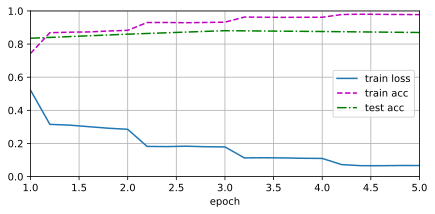

In [ ]:
''' Train and Evaluate the Model '''
lr, num_epochs = 0.001, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
train_nlp(net, train_iter, test_iter, loss, trainer, num_epochs, devices=gpus)

Insights

One-dimensional CNNs can process features such as n-grams in text. Multi-input-channel one-dimensional cross-correlations are equivalent to single-input-channel two-dimentional cross-correlation. The textCNN model transforms individual token representations into downstream application outputs using one-domensional convolutional layers and max-over-time pooling layers.

#### 4. **Natural Language Inference Dataset**

#### **5. Natural Language Inference Attention**

#### **6. Natural Language Inference Bert**

#### **7. Fine Tuning Bert**